# Coursework 2 - Atomistic simulation

Please enter your name and student number into the Markdown cell below.

#### Name: Yuyang Zhang
#### Student Number:11169535

In this coursework we will explore some important concepts from atomistic simulation in more detail. To keep the simulations simple, we will be simulating binary collisions rather than collision cascades, which can take a long time to run.

#### <span style="color: green"> General notes on marking (remove from student version):</span>
Allocation of marks is shown for each task.

Use half marks where necessary, for example:
- A correct plot without proper labelling or formatting should only get half a mark
- A partial explanation should only get half a mark
- Code which contains enough correct features but does not work should only get half marks

## Setup 

Please enter your Student ID in the cell below. This ID will be used throughout the coursework so please do not create any other variables named `ID`.

In [1]:
ID = 11169535
vpka = [50.0 + 10.0*ID%14747/14746,0.0,0.0]
print('Your PKA velocity for this notebook is defined as: (%f,%f,%f) ang/ps' % (vpka[0],vpka[1],vpka[2]))

Your PKA velocity for this notebook is defined as: (50.106605,0.000000,0.000000) ang/ps


Run the below cell to import some key modules.

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import timeit
from scipy.optimize import curve_fit 

We need to define all the functions needed to run a small molecular dynamics simulation. The cell below gathers together all the required functions from the Atomistic Simulation notebook. Execute the cell to define the functions: 

In [3]:
# Calculate Lennard-Jones potential energy of a pair of atoms
def lj(R,eps,r0,rcut,alpha):
    if R<=rcut:
        return eps*((r0/R)**12-2.0*(r0/R)**6)+alpha*eps
    else:
        return 0.0
    
# Calculate Lennard-Jones force between a pair of atoms
def flj(R,eps,r0,rcut,alpha):
    if R<=rcut:
        return 12*eps/r0*((r0/R)**7-(r0/R)**13)
    else:
        return 0.0
# Return potential energy of a system of atoms
def pe(r):
    pe = 0.0
    for i in range(len(r)):
        for j in range(i):
            disp = np.abs(r[j,:]-r[i,:]) # Calculate displacement between atoms
            for s in range(3): # Check if atoms are closer across periodic boundaries in each dimension
                if disp[s] > 0.5*boxsize[s]*cell[s,s]:
                    disp[s] = disp[s] - boxsize[s]*cell[s,s] # Adjust displacement for periodic boundary  
            R = np.linalg.norm(disp)
            pe = pe + lj(R,eps,r0,rcut,alpha)
    return pe

# Return kinetic energy of a system of atoms
def ke(v,m):
    mconv = 1.036e-4
    ke = 0.0
    for i in range(len(r)):
        ke = ke + m[i]*(v[i,0]*v[i,0] + v[i,1]*v[i,1] + v[i,2]*v[i,2])
    return 0.5*mconv*ke

# Calculate acceleration of a system of atoms
def calcaccln(a,r,m):
    mconv = 1.036e-4
    for i in range(len(r)):
        a[i,:] = 0.0
    for i in range(len(r)):
        for j in range(i):
            disp = (r[j,:]-r[i,:]) # Calculate displacement between atoms
            for s in range(3): # Check if atoms are closer across periodic boundaries in each dimension
                if disp[s] > 0.5*boxsize[s]*cell[s,s]:
                    disp[s] = disp[s] - boxsize[s]*cell[s,s] # Adjust displacement for periodic boundary
                elif disp[s] < -0.5*boxsize[s]*cell[s,s]:
                    disp[s] = disp[s] + boxsize[s]*cell[s,s] # Adjust displacement for periodic boundary    
            R = np.linalg.norm(disp)
            a[i,:] = a[i,:] + flj(R,eps,r0,rcut,alpha)*disp[:]/R/m[i]/mconv
            a[j,:] = a[j,:] - flj(R,eps,r0,rcut,alpha)*disp[:]/R/m[j]/mconv
    return R

# Evolve the positions, velocities and accelerations of a system of atoms by one timestep
def vv(r,v,a,m,dt):
    v += 0.5*a*dt
    r += v*dt
    calcaccln(a,r,m)
    v += 0.5*a*dt
    for s in range(3):
        for i in range(len(r)):
            if r[i,s] > boxsize[s]*cell[s,s]:
                r[i,s] = r[i,s] - boxsize[s]*cell[s,s]
    return

# Run a simulation and record key data
def run(r,v,a,m,dt,nsteps):
    R0 = [r[0,:].tolist()]
    R1 = [r[1,:].tolist()]
    V0 = [v[0,:].tolist()]
    V1 = [v[1,:].tolist()]
    A0 = [a[0,:].tolist()]
    A1 = [a[1,:].tolist()]
    pelog = [pe(r)]
    kelog = [ke(v,m)]
    #print('Running simulation of ' + str(nsteps) + ' steps')
    #print('Progress:')
    for t in range(nsteps):
        #if (t+1)%10 == 0:
        #    print(str(t+1) + '.', end='')
        vv(r,v,a,m,dt)
        R0.append(r[0,:].tolist())
        R1.append(r[1,:].tolist())
        V0.append(v[0,:].tolist())
        V1.append(v[1,:].tolist())
        A0.append(a[0,:].tolist())
        A1.append(a[1,:].tolist())
        pelog.append(pe(r))
        kelog.append(ke(v,m))
        #if (t+1)%100 == 0:
        #    print('')
    #print()
    return np.array(R0),np.array(R1),np.array(V0),np.array(V1),np.array(A0),np.array(A1),np.array(pelog),np.array(kelog)


### A note on units 
I have set up the Lennard-Jones potential and the initial velocity so that times are specified in picosecond (ps), distances in angstrom and energies in electron-volts (eV). Please use this system of units in your answers.

## Part 1 - The importance of the choice of timestep (13 marks)
Now we have everything set up. In this part of the coursework we will explore how the choice of timestep affects the behaviour and reliability of a simulation.

#### <span style="color: red"> Task 1a:</span> Set up a simulation cell for a binary collision (3 marks)

For guidance, look at the example of a binary collision at the end of the class notebook. Set up a simulation box of $8\times 4\times 4$ unit cells with a lattice parameter of 2.86 ang. You can use the motif for a bcc lattice, even though we are not actually going to populate the box with a full crystal. define an array `r[]` which places atoms at $(2.0,5.0,5.0)$ and $(7.0,5.0,5.0)$. Initialise the velocity and acceleration arrays with zeros and the mass array with all atoms having the Fe mass 55.8. Set up the parameters for the Lennard-Jones potential as in class.

In [4]:
L = 4 # Length of cube sides in unit cells
boxsize = np.array([2*L,L,L]) # Define a cubic box in multiples of the unit cell size in each direction

alatt = 2.86 # Lattice parameter
cell = np.array([
        [alatt,0,0],
        [0,alatt,0],
        [0,0,alatt]
    ]) # Specify vectors in rows of an array
motif = np.array([
        [0.0,0.0,0.0],
        [0.5,0.5,0.5] # Postions of atoms in motif in multiples of lattice vectors
    ])
nmotif = len(motif) # Number of atoms in motif

r = np.array([[2.0,5.0,5.0],[7.0,5.0,5.0]])
#plotcell(r)

natoms = len(r) # Get total number of atoms

mass = 55.8
m = np.full(natoms,mass)
v = np.zeros((natoms,3))
a = np.zeros((natoms,3))


alatt = 2.86
eps = 0.7511
r0 = 2.5614
rcut = 4.2914
alpha = 0.0884

#### <span style="color: red"> Task 1b:</span> Visualise the simulation cell (1 mark)
Produce a simple plot of the positions of the atoms as points in the x-y plane. Include some indication of the boundaries of the simulation cell, either as lines in the plot or by adjusting the x and y ranges of the plot.

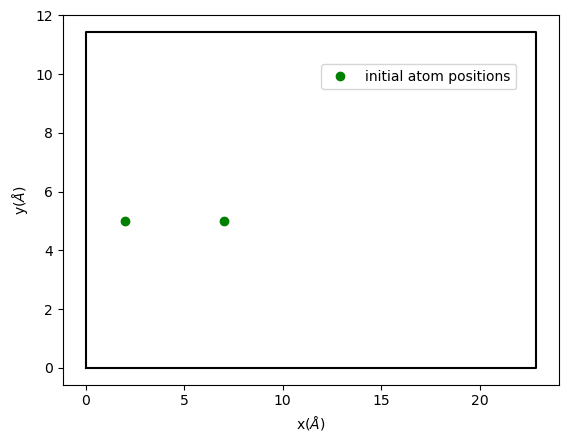

In [5]:
cellbox = np.array([
            [0,0],
            [0,4.0*alatt],
            [8.0*alatt,4.0*alatt],
            [8.0*alatt,0],
            [0,0]
])
plt.plot(r[:, 0], r[:, 1], 'go', label='initial atom positions')
plt.plot(cellbox[:, 0], cellbox[:, 1], 'k-')
plt.xlabel('x($\AA$)')
plt.ylabel('y($\AA$)')
plt.legend(loc=(0.52,0.8))
plt.show()

#### <span style="color: red"> Task 1c:</span> Run a simulation (1 mark)
Initialise the velocity of atom 0 in the simulation to the value of vpka that was initialised at the start of the notebook. Run a simulation with a timestep of 0.0001 for 2000 timesteps. 

In [6]:
dt = 0.0001
v[0,:] = vpka
R0,R1,V0,V1,A0,A1,pelog,kelog = run(r,v,a,m,dt,2000)

#### <span style="color: red"> Task 1d:</span> Plot the change in total energy as a function of time (2 marks)
Produce a plot of the change in total energy (i.e. the difference between the total energy at each timestep and the energy at the start of the simulation) against the number of timesteps into the simulation. You should see two step-like features and an oscillating feature. In a markdown cell, explain what gives rise to each of these features [Hint: it might help to think about what this plot would look like if the simulation was perfect].

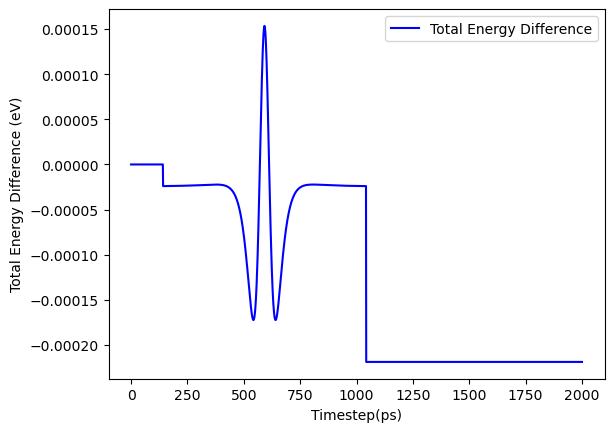

In [7]:
plt.plot((kelog[:]+pelog[:])-(kelog[0]+pelog[0]), 'b-', label='Total Energy Difference')
plt.legend()
plt.xlabel('Timestep(ps)')
plt.ylabel('Total Energy Difference (eV)')
plt.show()

Divide the graph into three stages: 
First,**R>Rcut**. Before the two atoms collide, the energy is conserved and the difference is zero. At this point the potential energy is zero based on the program we write.
When **R=Rcut**, program start calculating the potential energy. Since the potential energy is negative at Rcut, it will show a sudden change in value.To reduce this error, Rcut need to be setted larger.
In the second stage, when **R<Rcut**, we divide the potential energy into n timesteps and consider these to be linear superposition during calculation. Therefore there will be a difference caused by the integral compared to the theoretical nonlinear function. Since kinetic energy is differentiated, it is more accurate compared to potential energy. The difference when integrating the potential energy results in an oscillation with three peaks, corresponding to the Leonard-Jones potential. The error can be reduced by increasing the time step.
In the third stage, **R>rcut**, after two atoms collide, the potential energy changes to 0 again at the boundary. Therefore, a stage-like numerical mutation occurs again.

#### <span style="color: red"> Task 1e:</span> Explore the effect of the timestep on energy conservation ( 2 marks)
Run simulations of collisions just like the one above for a range of values of the timestep `dt`. Use the following values for the timestep $[0.00001, 0.0001, 0.001, 0.01]$. For each choice of timestep you will need a different number of steps in your simulation to ensure that the overall duration of the simulation remains the same. The corresponding set of numbers of steps will be $[20000,2000,200,20]$.

For each simulation, record the change in total energy between the first and last step in a list. This is a measure of the lack of energy conservation in the simulation.

[Hint: By placing the values for the timestep and the number of steps in a list, you can define a loop and for each simulation append the change in total energy to a list of energy changes. This is the most efficient way to achieve the task and you will  gain full marks only if you use this approach. An alternative is to explore the timesteps manually and record the resulting energy differences in a list by hand, but this will not gain you full marks. The class notebook included an example of using a python loop to execute a series of simulations.]

[Hint: Remember that for each simulation you will need to reinitialise the arrays of positions, velocities and acceleration, otherwise you will start with the values from the end of the previous simulation!] 

In [8]:
initt = [0.00001, 0.0001, 0.001, 0.01]
inistep=[20000,2000,200,20]
deltaE = []
for i in range(4):
    r= np.array([[2.0,5.0,5.0],[7.0,5.0,5.0]])
    natoms = len(r) # Get total number of atoms
    m = np.full(natoms,mass)
    v = np.zeros((natoms,3))
    a = np.zeros((natoms,3))
    dt = initt[i]
    ts = inistep[i] #define timestep
    v[0,:] = vpka
    R0,R1,V0,V1,A0,A1,pelog,kelog = run(r,v,a,m,dt,ts)
    deltaE.append(kelog[ts]+pelog[ts]-(kelog[0]+pelog[0]))
print(deltaE)

[-3.673155570549369e-05, -0.0002187352114386698, -0.0030367025466055964, 110322924284.7913]


#### <span style="color: red"> Task 1f:</span> Plot a graph of energy change against the value of the timestep `dt` (2 marks)
Plot the *absolute* value of the energy change against the value of timestep `dt` using a log-log scale. Remember that the total energy should be conserved, so any change represents an error in our simulation.

In a markdown cell, comment on the resulting graph. How would you explain the resulting behaviour? At what value of the timestep does the change in total energy become intolerably large?

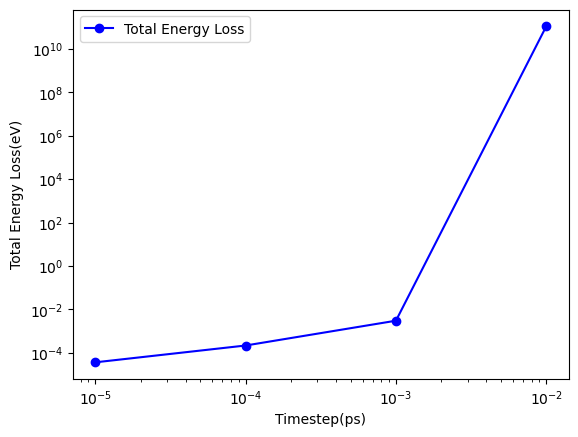

In [9]:
plt.loglog(initt[:], abs(np.array(deltaE)), 'bo-',label='Total Energy Loss')
plt.xlabel('Timestep(ps)')
plt.ylabel('Total Energy Loss(eV)')
plt.legend()
plt.show()

From the graph, it can be observed that as the time interval increases, the computational error remains relatively small and is generally proportional to the logarithm of the time interval when t < 10^-3. At 10^-2, the error significantly increases. This is due to the approximation of the Lennard-Jones potential being overly coarse due to the small steps. Generally, the step size should not exceed 10% of the key oscillation period, in this case is approximately 0.005 ps. Otherwise, due to the inability to compute processes such as collisions in nonlinear processes[1], the incident particle “passes through” the stimulated atom. This results in a substantial increase in the calculated error.


[1]refer from *Molecular modelling Principles and applications(Leach A.R.,2ed,2001)*.

#### <span style="color: red"> Task 1g:</span> Plot a graph of the distance moved by the projectile atom (atom 0) in the first timestep of the simulation (2 marks)
Calculate the distance moved by the projectile atom in the first timestep of the simulation for each value of the timestep `dt`. Plot this distance against the timestep `dt` on a log-log plot (Hint: you do not need any simulation results in order to complete this task). In a markdown cell, comment on the value that you obtain for the displacement per timestep for the longest timestep in light of your plot of energy change above. 

[0.0005010660518105503, 0.005010660518106391, 0.05010660518106613, 0.5010660518106604]


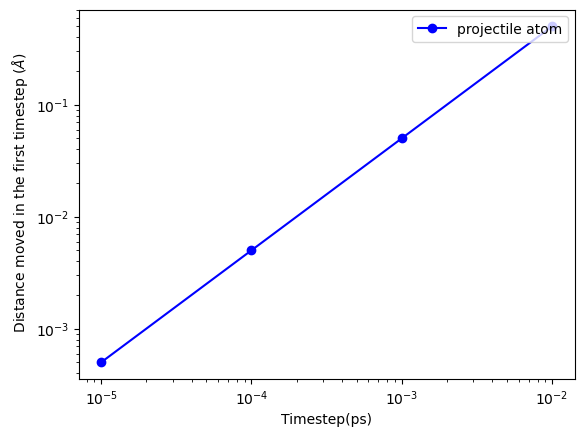

In [10]:
Distance = [] #The distance moved by the atom 0 in the different first timestep
for i in range(4):
    dt = initt[i]
    r = np.array([[2.0,5.0,5.0],[7.0,5.0,5.0]])
    r1=r[0,0]
    natoms = len(r)
    m = np.full(natoms,mass)
    v = np.zeros((natoms,3))
    a = np.zeros((natoms,3)) 
    v[0,:] = vpka
    vv(r,v,a,m,dt)
    R0=r[0,:].tolist()
    Distance.append(R0[0] - r1)
print(Distance)
plt.loglog(initt, Distance, 'bo-',label='projectile atom')
plt.xlabel('Timestep(ps)')
plt.ylabel(' Distance moved in the first timestep ($\AA$)')
plt.legend(loc='upper right')
plt.show()

Since the iteration has not started during the first step, the size of the displacement in the first step is simply `Vpka * dt`. Therefore, the graph in a logarithmic coordinate system appears as a straight line. Upon comparison, it can be observed that in the Lennard-Jones potential, the difference in distance between the lowest and highest points of potential energy is only 1 Ångström. Consequently, during computation, since the maximum displacement corresponding to the initial movement at the largest time step is already 0.5 Ångström, it is easy for penetration to occur during the acceleration phase, failing to compute up to the highest energy point. This leads to significant errors.


In [11]:
Q1 = 13 #well done!

## Part 2 - Energy transfer (8 marks)
We will now investigate the amount of energy tranferred from the projectile atom (atom 0) to the target atom (atom 1) during the collision as a function of the *impact parameter* of the collision. The impact parameter is defined as the perpendicular distance of the target atom from a straight line projection of the initial trajectory of the projectile atom as shown below

![](Figures/ImpactParameter.png "")


As well as simulating the collision process we will consider it in an analytical treatment and see how well a simple theory matches our results.

#### <span style="color: red"> Task 2a:</span> Define a function to return the value of the kinetic energy for a single atom (1 mark)
In the code cell below, define a new function called `keatom()` which takes two arguments, the first being an array (or list) containing the three components of an atom's velocity and the second being the mass of the atom. The function should return the kinetic energy of the atom (in eV).

[Hint: The function `ke()` defined at the start of the notebook will provide a useful guide for how to complete this task.]

In [12]:
def keatom(v,m):
    ke=0.0
    mconv = 1.036e-4
    ke=m[0]*(v[0]*v[0] + v[1]*v[1] + v[2]*v[2])
    return 0.5*mconv*ke

#### <span style="color: red"> Task 2b:</span> Run simulations with a variety of impact parameters (2 marks)
Run a set of six simulations with impact parameters `b = [0.0,0.1,0.2,0.5,1.0,2.0]` and for each simulation record the fraction of the initial projectile kinetic energy transferred to the target atom. For each simulation, use the initial velocity `vpka` that was set at the start of the notebook. Once again, to gain full marks you must use a loop to run the multiple simulations. A timestep of 1e-4 should be suitable.

[Hint: To give the correct impact parameter, simply set the starting position of the projectile atom for each value of `b` to `[2.0,5.0+b,5.0]`.

[Hint 2: Remember that the kinetic energy of the target atom is zero at the start of the simulation. The potential energy will be zero at the start and end because the atoms are out of range of one another. This makes it easy to calculate the kinetic energy gained by the target.] 

In [13]:
b=[0.0,0.1,0.2,0.5,1.0,2.0]
ke1=[]
ke0=np.full(6,keatom(vpka,m))
for i in range(len(b)):
    r= np.array([[2.0,5.0+b[i],5.0],[7.0,5.0,5.0]])
    natoms = len(r) # Get total number of atoms
    mass=55.8
    m = np.full(natoms,mass)
    v = np.zeros((natoms,3))
    a = np.zeros((natoms,3))
    v[0,:] = vpka
    dt=0.0001
    R0,R1,V0,V1,A0,A1,pelog,kelog = run(r,v,a,m,dt,2000)
    v1=V1[-1,:]
    ke1.append(keatom(v1,m))
fracke1=ke1/ke0
print(fracke1)

[0.99996986 0.99754628 0.99010196 0.93865064 0.76213927 0.19717477]


#### <span style="color: red"> Task 2c:</span> Plot the fraction of kinetic energy trasferred as a function of impact parameter (1 mark)
Plot the results of the above computer experiment on a plot with linear scales.

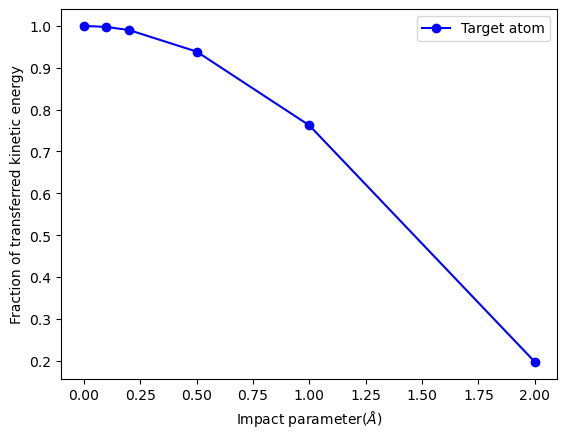

In [14]:
plt.plot(b,fracke1,'bo-',label='Target atom')
plt.xlabel('Impact parameter($\AA$)')
plt.ylabel('Fraction of transferred kinetic energy')
plt.legend()
plt.show()

### A theoretical treatment of the collision
The above plot should show a well behaved trend. Can we explain the form of this trend using some simple theory?

First, let's make some simplifications in our analysis of the collision process. Let's assume that the interaction between the atoms is only significant when they are within a certain range that we denote $r^{\ast}$. This means that the forces between the atoms will only act to transfer energy when the atoms are within a distance of $r^{\ast}$ or less. We will also assume that we can approximate the energy transfer in the true collision process by assuming that it is the same as would have occurred if the particles followed their unperturbed paths (i.e. the target atom remains stationary and the projectile moves in a straight line. The figure below illustrates this approximate scenario for a given impact parameter.

![](Figures/CollisionTime.png "Logo Title Text 1")


You may recall that the change in momentum of a particle (also called an *impulse*) $\Delta p$ of a particle experiencing a force $F$ for a time $t$ is given by $\Delta p = F t$ (you can see this if you remember Newton's second law, that a force is a rate of change of velocity multipled by mass). Now, since the target particle is initially at rest, the kinetic energy transfer is simply the value of its final kinetic energy. If it receives momentum $\Delta p$ then this kinetic energy change is:

$$
\Delta E_{\mathrm{kin}} = \frac{\Delta p^2}{2m}.
$$

Now, from the figure, we can see that the length of the projectile trajectory within range $r^{\ast}$ is given by $x = 2\,\sqrt{{r^{\ast}}^2-b^2}$ which, for a projectile speed $v$ implies a time over which a significant force acts of

$$
t = x/v = 2(\sqrt{{r^{\ast}}^2-b^2})/v.
$$

Inserting this into our expression for the kinetic energy transfer and gathering together the various factors into a constant $\beta$ gives

$$
\Delta E_{\mathrm{kin}} = \frac{\Delta p^2}{2m} = \frac{(F\,t)^2}{2m} = \frac{F^2}{2m v^2}4({r^{\ast}}^2-b^2) = \beta \,({r^{\ast}}^2-b^2).
$$

Now, we know from basic physics that in a perfectly elastic head-on collision between two particles of equal mass, the kinetic energy transfer is complete. This is to say that the value of $\Delta E_{\mathrm{kin}}$ must be 1.0 when $b=0$, which means we must have $\beta { r^{\ast}}^2=1$,  and so our final theoretical expression reads:

$$
\Delta E_{\mathrm{kin}} = 1 -\beta b^2.
$$

A more sophisticated treatment would allow us to calculate the value of the parameter $\beta$ directly, but this would involve an integral over the Lennard-Jones potential and would in any case give the wrong answer because some of the assumptions that we have made in our analysis are a little too agressive for the low collision velocities that we are simulating. However, what we can do is fit the value of $\beta$ to our simulation data to verify the *form* of the model that we have derived.

#### <span style="color: red"> Task 2d:</span> Define a python function for the kinetic energy tranfer as a function of impact parameter and fit the value of the $\beta$ parameter (2 marks)
Define a python function `demodel()` that takes a value of the impact parameter `b` and a value for the constant `beta` and returns a value for the kinetic energy transfer according to the equation that we derived above. Use what you learned about curve fitting earlier in the module to fit the value of the parameter `beta` to the output from your simulations.

In [15]:
def demodel(b,beta):
    b=np.array(b)
    return 1-beta*b**2
par=curve_fit(demodel,b,fracke1)
beta=par[0]
space=np.linspace(0,2,1000)
fit=demodel(space,beta)
print(beta)

[0.20305197]


#### <span style="color: red"> Task 2e:</span> Plot the fitted model against the simulation data (1 mark)
Produce a plot of the simulation data and the fitted model on the same axes and comment on the fit.

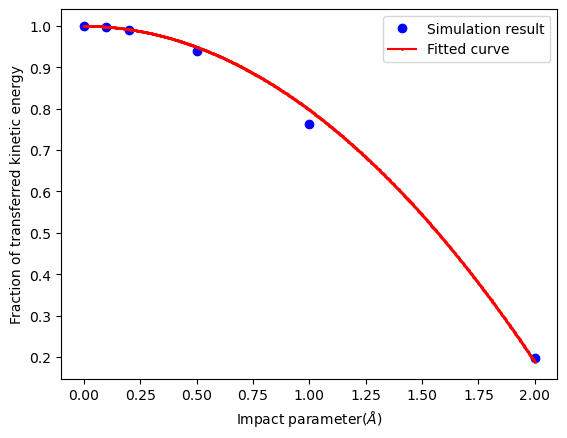

In [16]:
plt.plot(b,fracke1,'bo',label='Simulation result')
plt.plot(space,fit,'ro-',markersize=1,label='Fitted curve')
plt.xlabel('Impact parameter($\AA$)')
plt.ylabel('Fraction of transferred kinetic energy')
plt.legend()
plt.show()

This result indicates that as the *impact parameter* increases, the *Fraction of transferred kinetic energy* becomes smaller. This conclusion can also be derived from the analysis of the scattering angles. When *b* (the impact parameter) increases, scattering occurs, altering the direction of the incident atom. In this scenario, since the final velocity is not zero, the incident atom retains a certain amount of kinetic energy. This ultimately leads to an increase in the *Fraction of transferred kinetic energy*.This can also be obtained through extrapolation. When *b* approaches positive infinity, no energy transfer occurs, and the *Fraction of transferred kinetic energy* equals zero, similar to the Rutherford scattering experiment.



#### <span style="color: red"> Task 2f:</span> Calculate the value of $r^{\ast}$ (1 mark)
Calculate the value of $r^{\ast}$ implied by your simulation data. Comment on the value you obtain with respect to the shape of the Lennard-Jones potential with the parameterisation for Fe. [Hint: Think about the shape of the Lennard-Jones curve and how it is made up of a repulsive and an attractive contribution.]

In [17]:
r_star = np.sqrt(1/beta)
print(r_star)

[2.21919975]


$r^{\ast}$ is the distance when protential starts to become unneglectable.in the simulation, the point where protential took place is larger than the result so here the result is reliable.By calculating the neighbour shells around the atom for iron, the theoretical value for $r^{\ast}$ is found to be 2.5614 Ångströms. However, the value obtained from fitting is 2.21920 Ångströms, which is less than the theoretical value. This discrepancy may arise from the assumption that the target particle is stationary. In reality, at the end of this process, the target particle has moved a certain distance due to the transfer of kinetic energy. Therefore, the obtained $r^{\ast}$ should be adjusted by adding a term for the movement of the center of mass of the diatomic system. This issue was not considered in our assumption, leading to a value slightly lower than the reference value.During the collision process.The forces corresponding to the potential energy (van der Waals forces) cause the incident atom's velocity to vary due to alternating attractive and repulsive forces. In fact, in this energy expression, two forces act together: a long-range attractive force and a short-range repulsive force. The repulsive force dominates the motion when the interatomic distance is less than $r^{\ast}$ while the attractive force dominates when the interatomic distance is greater than $r^{\ast}$. When r=$r^{\ast}$ it's the equabilium point of the repulsive force and the attractive force，This results in the velocity first accelerating, then decelerating, and finally accelerating again, rather than maintaining a uniform speed as initially assumed. Therefore, the calculation of time is also imprecise. The fitting results are impacted by this factor.



In [18]:
Q2 = 7

# (e) -0.5 Comments should be on the fit. i.e. the fit is not very accurate for b > 0.25.
# (f) -0.5 Comments should be on the placement of r* on the LJ curve. i.e. r* is in the strongly repuslive region of the LJ potential.

## Part 3 -  (4 marks)
Read the following instructions very carefully. To earn all the marks for this part you must do everything asked for.

#### <span style="color: red"> Task 3:</span> (4 marks)
Run a set of simulations using values for the impact parameter of `b=[0.05,0.1,0.2,0.5,1.0,2.0,3.0]`. Note that this is a slightly different set to before. Produce a *single* plot showing the trajectories followed by the projectile in the x-y plane for all of the simulations. Make sure your plot makes it possible to distinguish which trajectory corresponds to which value of the impact parameter. Next produce a plot which shows how the angle of deflection of the final projectile path varies as a function of impact parameter across your set of simulations. Finally, in a markdown cell, explain the behaviour of the simulation for `b=3.0`.

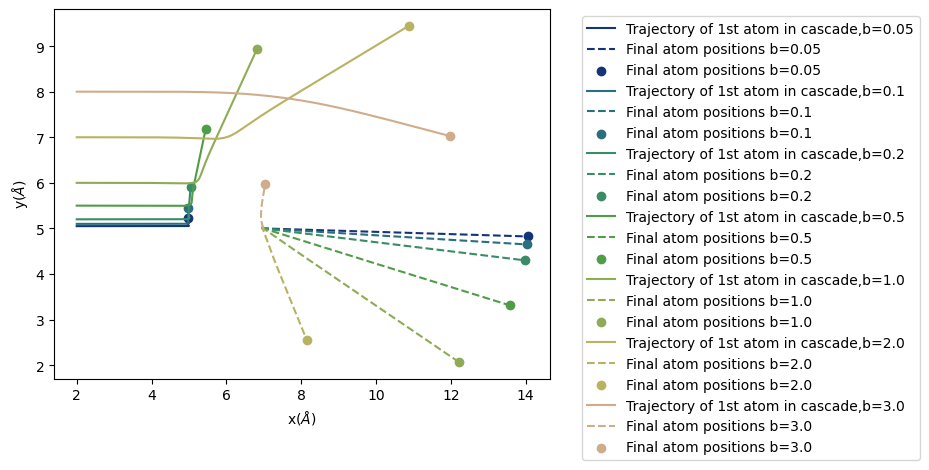

In [19]:
from matplotlib import cm
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

b = [0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 3.0]
angle = []

cmap = cm.gist_earth
norm = Normalize(vmin=min(b), vmax=max(b))
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])


for i in range(7):
    r = np.array([[2.0, 5.0 + b[i], 5.0], [7.0, 5.0, 5.0]])
    natoms = len(r)  # Get the total number of atoms
    m = np.full(natoms, mass)
    v = np.zeros((natoms, 3))
    a = np.zeros((natoms, 3))
    dt = 0.0001
    ts = 2000
    v[0, :] = vpka
    R0, R1, V0, V1, A0, A1, pelog, kelog = run(r, v, a, m, dt, ts)

    dot_product = np.dot(V0[-1], [1, 0, 0])  # Calculate the angle
    magnitude_vector1 = np.linalg.norm(V0[-1])
    magnitude_vector2 = np.linalg.norm([1, 0, 0])
    angle_radians = np.arccos(dot_product / (magnitude_vector1 * magnitude_vector2))
    angle_degrees = np.degrees(angle_radians)
    angle.append(angle_degrees)

    # Plot the diagram
    g = 0.12 * (i + 1)
    plt.plot(R0[:, 0], R0[:, 1], color=cmap(g), linestyle='-', label=f'Trajectory of 1st atom in cascade,b={b[i]}')
    plt.plot(R1[:, 0], R1[:, 1], color=cmap(g), linestyle='--',label=f'Final atom positions b={b[i]}')
    plt.scatter(r[:, 0], r[:, 1], color=cmap(g), marker='o' ,  label=f'Final atom positions b={b[i]}')
    

plt.xlabel('x($\AA$)')
plt.ylabel('y($\AA$)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()


In [40]:
from matplotlib import cm
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

b = [0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 3.0]
angle = []
cmap = cm.gist_earth
norm = Normalize(vmin=min(b), vmax=max(b))
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])


for i in range(7):
    r = np.array([[2.0, 5.0 + b[i], 5.0], [7.0, 5.0, 5.0]])
    natoms = len(r)  # Get the total number of atoms
    m = np.full(natoms, mass)
    v = np.zeros((natoms, 3))
    a = np.zeros((natoms, 3))
    dt = 0.0001
    ts = 2000
    v[0, :] = vpka
    R0, R1, V0, V1, A0, A1, pelog, kelog = run(r, v, a, m, dt, ts)

    dot_product = np.dot(V0[-1], [1, 0, 0])  # Calculate the angle
    magnitude_vector1 = np.linalg.norm(V0[-1])
    magnitude_vector2 = np.linalg.norm([1, 0, 0])
    angle_radians = np.arccos(dot_product / (magnitude_vector1 * magnitude_vector2))
    angle_direction = np.cross(V0[-1], [1, 0, 0])
    angle_degrees = np.degrees(angle_radians)
    if angle_direction < 0:
        angle_degrees=-angle_degrees
    
    angle.append(angle_degrees)

    # Plot the diagram
    g = 0.12 * (i + 1)
    plt.plot(R0[:, 0], R0[:, 1], color=cmap(g), linestyle='-', label=f'Trajectory of 1st atom in cascade,b={b[i]}')
    plt.plot(R1[:, 0], R1[:, 1], color=cmap(g), linestyle='--',label=f'Final atom positions b={b[i]}')
    plt.scatter(r[:, 0], r[:, 1], color=cmap(g), marker='o' ,  label=f'Final atom positions b={b[i]}')
    

plt.xlabel('x($\AA$)')
plt.ylabel('y($\AA$)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

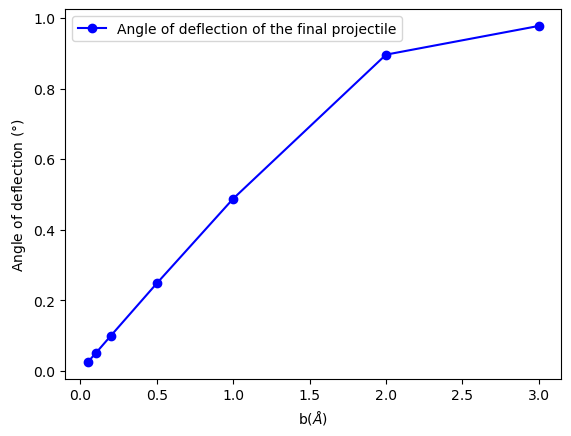

In [31]:
plt.plot(b,cos_lists,'bo-', label=f'Angle of deflection of the final projectile')
plt.xlabel('b($\AA$)')
plt.ylabel('Angle of deflection ($\degree$)')
plt.legend()
plt.show()

When *b* = 3.0, the distance between the two atoms is too great, and the Lennard-Jones potential is dominated by attractive forces. As a result, similar to how the Earth orbits around the Sun, due to the initial velocity, the two atoms cannot decrease their distance to the point where repulsive forces begin to dominate at $r^{\ast}$. Therefore, the incident atom is attracted by the target atom, resulting in an orbital deflection. In contrast, other atoms can get close enough to within $r^{\ast}$ where the strong repulsive forces cause these atoms to move away from the target atom.


In [22]:
Q3 = 3.5

# -0.5 The defelction angle when b = 3.0 should be negative (be considerate of the directionality of angles)

### For use by markers only:

#### Total mark: 23.5/25

#### As a percentage: 94%

In [23]:

Total_Marks = Q1 + Q2 + Q3
Percentage = round(((float(Total_Marks)/25)*100), 2)
print(''.rjust(16) + 'Question'.rjust(16) + 'Marks'.rjust(16))
print('------------'.rjust(16) + '------------'.rjust(16) + '------------'.rjust(16))
print(''.rjust(16) + 'Q1'.rjust(12) + str(Q1).rjust(16)+'/13')
print(''.rjust(16) + 'Q2'.rjust(12) + str(Q2).rjust(16)+'/8')
print(''.rjust(16) + 'Q3'.rjust(12) + str(Q3).rjust(16)+'/4')
print('Total'.rjust(16) + ''.rjust(12) + str(Total_Marks).rjust(16)+'/25')
print('%'.rjust(16) + ''.rjust(14) + str(Percentage).rjust(17))

                        Question           Marks
    ------------    ------------    ------------
                          Q1              13/13
                          Q2               7/8
                          Q3             3.5/4
           Total                        23.5/25
               %                           94.0
